In [1]:
# imports
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Ignore wernings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)


import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# plotting defaults
plt.rc('figure', figsize=(13, 7))
# plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

# Acquire

In [2]:
# load data into a pandas data frame
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Prepare

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.shape

(6435, 8)

In [6]:
# for empty values
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

## Takeaways 
- There are 6435 records 
- 8 Columns
- There are 0 empty values
- Columns have a miss of upper and lower case caracters
    - We will turn them to lower case for 

In [7]:
# Chanege CPI for Consumer Price Index
df.rename(columns={'CPI':'Consumer_Price_Index'}, inplace=True)


In [8]:
# turn the name of the columns to only contain lower case charactes x
df.columns= df.columns.str.lower()
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'consumer_price_index', 'unemployment'],
      dtype='object')

In [9]:
# Ovser that data from has the propper columnbs
df.sample()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
3590,26,21-05-2010,986765.01,0,50.81,2.961,132.223032,8.512


In [10]:
# Convert our date column from object type to datetime type
df.date = pd.to_datetime(df.date)
df.dtypes

store                            int64
date                    datetime64[ns]
weekly_sales                   float64
holiday_flag                     int64
temperature                    float64
fuel_price                     float64
consumer_price_index           float64
unemployment                   float64
dtype: object

In [11]:
# # Create features that indicate day, month, year, and weekday
# df['year'] = df.date.dt.year
# df['month'] = df.date.dt.month
# df['day'] = df.date.dt.month
# df['weekday'] = df.date.dt.day_name()
# df.head()

In [12]:
# set the date as index
df = df.set_index('date').sort_index()
df

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2010-01-10,5,283178.12,0,71.10,2.603,212.226946,6.768
2010-01-10,15,566945.95,0,59.69,2.840,132.756800,8.067
2010-01-10,42,481523.93,0,86.01,3.001,126.234600,9.003
2010-01-10,33,224294.39,0,91.45,3.001,126.234600,9.265
2010-01-10,36,422169.47,0,74.66,2.567,210.440443,8.476
...,...,...,...,...,...,...,...
2012-12-10,41,1409544.97,0,39.38,3.760,199.053937,6.195
2012-12-10,16,491817.19,0,43.26,3.760,199.053937,5.847
2012-12-10,10,1713889.11,0,76.03,4.468,131.108333,6.943


# Exploratory Analysis

In [13]:
# what dates does your data set cover
df.index.min(), df.index.max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-12-10 00:00:00'))

- Hour data set covers almost three years of data

In [14]:
df.nunique().sort_values()

holiday_flag               2
store                     45
unemployment             349
fuel_price               892
consumer_price_index    2145
temperature             3528
weekly_sales            6435
dtype: int64

<AxesSubplot:xlabel='date'>

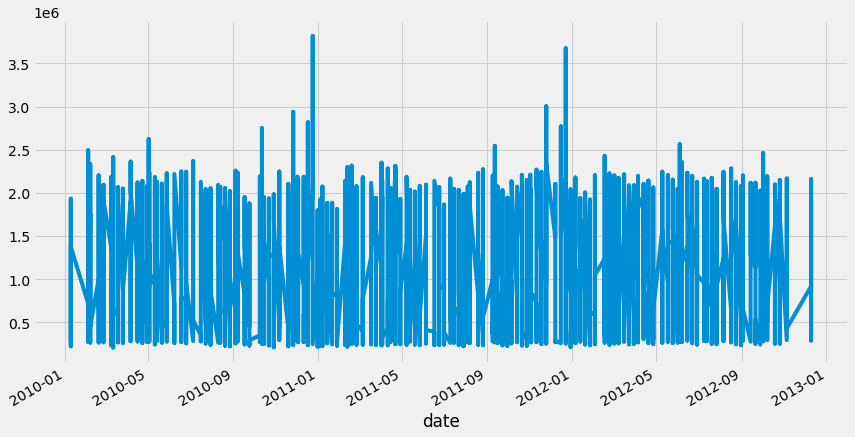

In [15]:
#lets visulize our data
df.weekly_sales.plot()

<AxesSubplot:xlabel='date'>

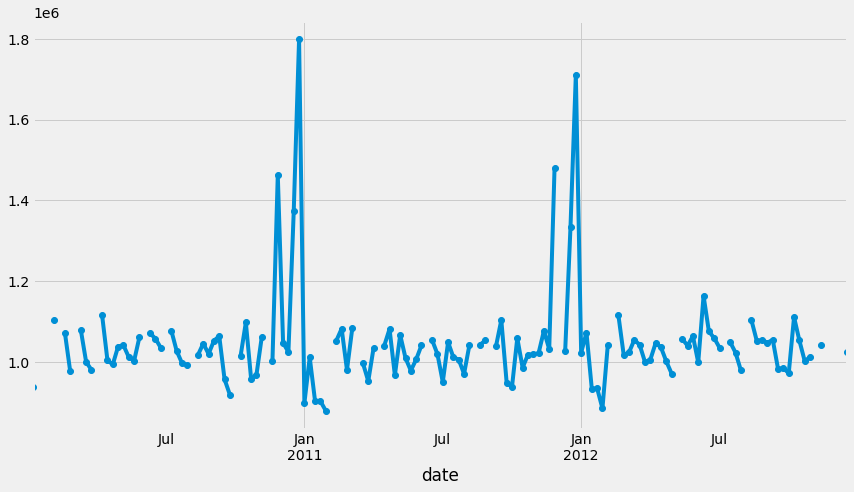

In [16]:
#  let's visualize Theden by weekly 
df.weekly_sales.resample('w').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

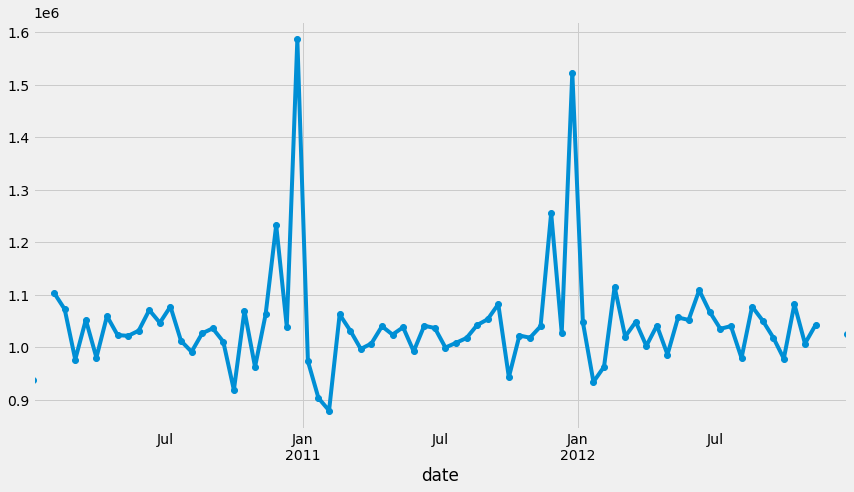

In [17]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('2w').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

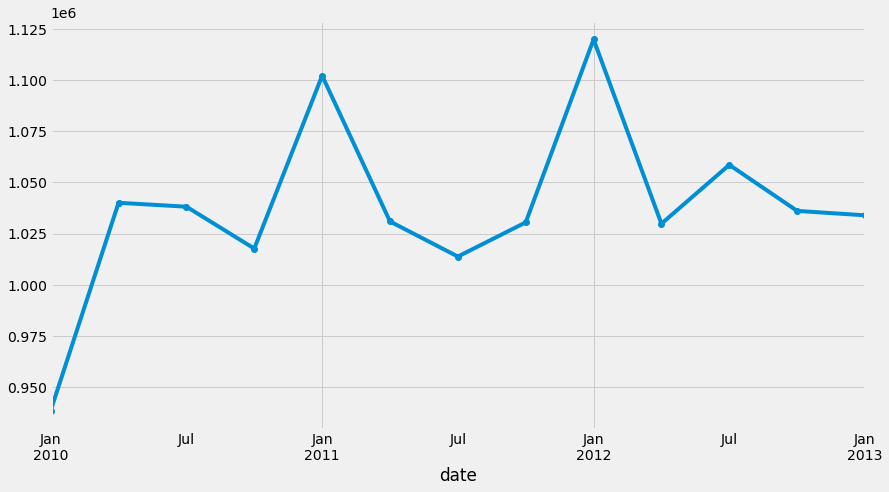

In [18]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('3M').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

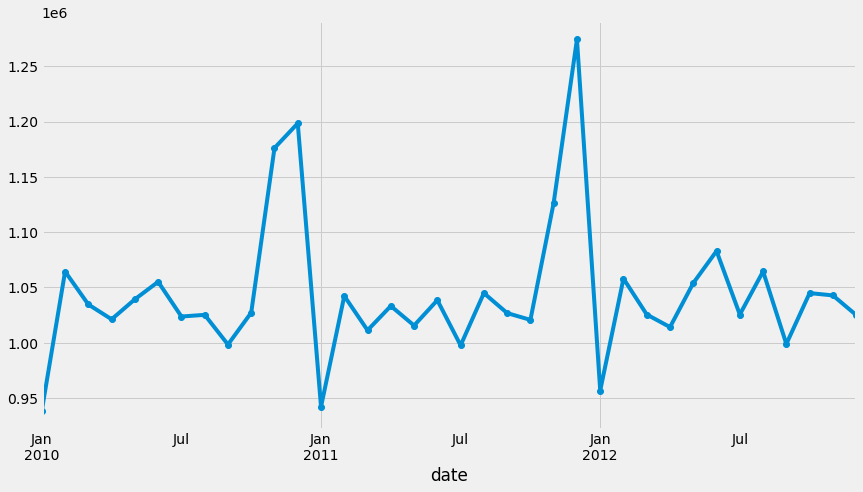

In [19]:
# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('M').mean().plot(marker='o')

,rolling_3,rolling_5,rolling_7
date,,,
2010-01-10,NaN,NaN,NaN
2010-01-17,NaN,NaN,NaN
2010-01-24,NaN,NaN,NaN
2010-01-31,NaN,NaN,NaN
2010-02-07,NaN,NaN,NaN
2010-02-14,NaN,NaN,NaN
2010-02-21,NaN,NaN,NaN
2010-02-28,NaN,NaN,NaN
2010-03-07,NaN,NaN,NaN


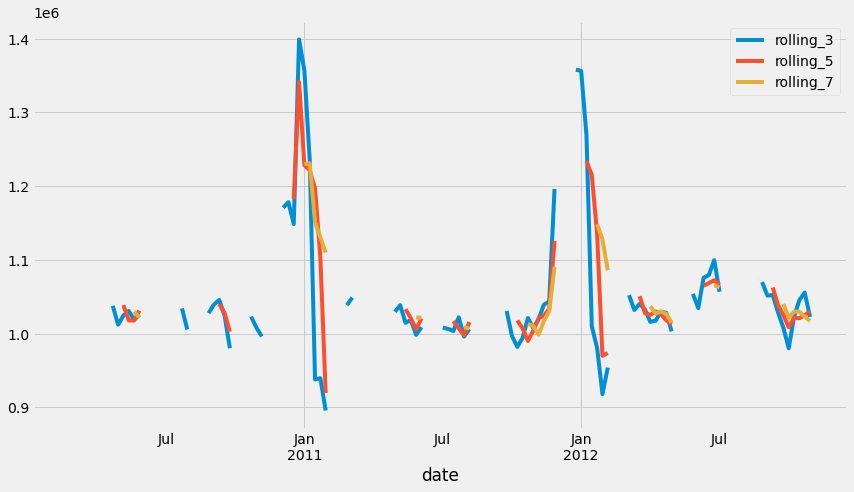

In [20]:
# Rolling Averages evry week
rolling_df = df.resample('W').mean().assign(
    rolling_3=lambda df: df.weekly_sales.rolling(3).mean(),
    rolling_5=lambda df: df.weekly_sales.rolling(5).mean(),
    rolling_7=lambda df: df.weekly_sales.rolling(7).mean(),
)
# delete colums to see targets rolling averages in 2 wweks, a month and quarterly
del rolling_df['weekly_sales']
del rolling_df['store']
del rolling_df['holiday_flag']
del rolling_df['temperature']
del rolling_df['fuel_price']
del rolling_df['consumer_price_index']
del rolling_df['unemployment']
rolling_df.plot()
rolling_df.head(20)

,rolling_3,rolling_5,rolling_7
date,,,
2010-01-10,NaN,NaN,NaN
2010-01-24,NaN,NaN,NaN
2010-02-07,NaN,NaN,NaN
2010-02-21,NaN,NaN,NaN
2010-03-07,1.051231e+06,NaN,NaN
2010-03-21,1.034146e+06,NaN,NaN
2010-04-04,1.003456e+06,1.037397e+06,NaN
2010-04-18,1.030994e+06,1.028577e+06,NaN
2010-05-02,1.021359e+06,1.018739e+06,1.038615e+06


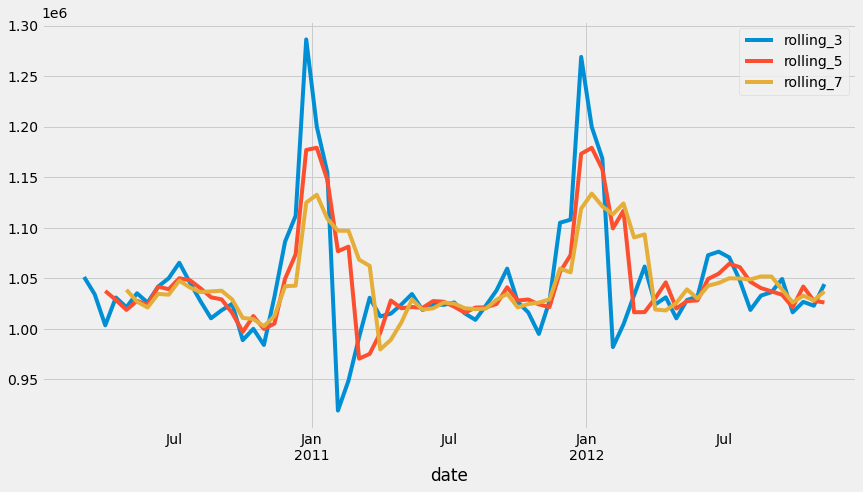

In [21]:
# Rolling Averages for dara downsampled to every 2 weeks 
rolling_df = df.resample('2W').mean().assign(
    rolling_3=lambda df: df.weekly_sales.rolling(3).mean(),
    rolling_5=lambda df: df.weekly_sales.rolling(5).mean(),
    rolling_7=lambda df: df.weekly_sales.rolling(7).mean(),
)

# delete colums to see targets rolling averages in 2 wweks, a month and quarterly
del rolling_df['weekly_sales']
del rolling_df['store']
del rolling_df['holiday_flag']
del rolling_df['temperature']
del rolling_df['fuel_price']
del rolling_df['consumer_price_index']
del rolling_df['unemployment']
rolling_df.plot()
rolling_df.head(20)

## Takeaways
- or data runs from **2010-01-10'** to **'2012-12-10'**
- Walmart seems to experience seasonality around the months of November and December
- Ther are alot of gaps in daily data
    -Data set before split need to downsampled to evry 2 weeks so that there are no gaps 


# Split

In [22]:
downsample_data = df.resample('2w').mean()
downsample_data.head(10)

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2010-01-10,23.0,9.386639e+05,0.0,69.868000,2.734333,168.354706,8.475289
2010-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-07,23.0,1.103792e+06,0.0,65.127111,2.810422,167.885568,8.463144
2010-02-21,23.0,1.072822e+06,0.0,37.719778,2.672067,167.871686,8.619311
2010-03-07,23.0,9.770794e+05,0.0,39.243556,2.683933,167.909657,8.619311
2010-03-21,23.0,1.052535e+06,0.0,55.995778,2.816304,168.212111,8.507726
2010-04-04,23.0,9.807547e+05,0.0,48.473556,2.824111,167.859731,8.619311
2010-04-18,23.0,1.059691e+06,0.0,65.716000,2.848900,167.789188,8.497711
2010-05-02,23.0,1.023632e+06,0.0,49.660519,2.830370,167.650884,8.538244


In [28]:
downsample_data.dropna(inplace=True)

In [30]:
downsample_data.isna().sum()

store                   0
weekly_sales            0
holiday_flag            0
temperature             0
fuel_price              0
consumer_price_index    0
unemployment            0
dtype: int64

In [32]:
downsample_data.shape

(75, 7)

In [23]:
df.head(10)

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2010-01-10,5,283178.12,0,71.10,2.603,212.226946,6.768
2010-01-10,15,566945.95,0,59.69,2.840,132.756800,8.067
2010-01-10,42,481523.93,0,86.01,3.001,126.234600,9.003
2010-01-10,33,224294.39,0,91.45,3.001,126.234600,9.265
2010-01-10,36,422169.47,0,74.66,2.567,210.440443,8.476
2010-01-10,40,891152.33,0,62.01,2.717,132.756800,5.287
2010-01-10,43,657108.77,0,77.93,2.603,203.593429,10.210
2010-01-10,1,1453329.50,0,71.89,2.603,211.671989,7.838
2010-01-10,28,1203080.41,0,85.20,3.001,126.234600,14.313


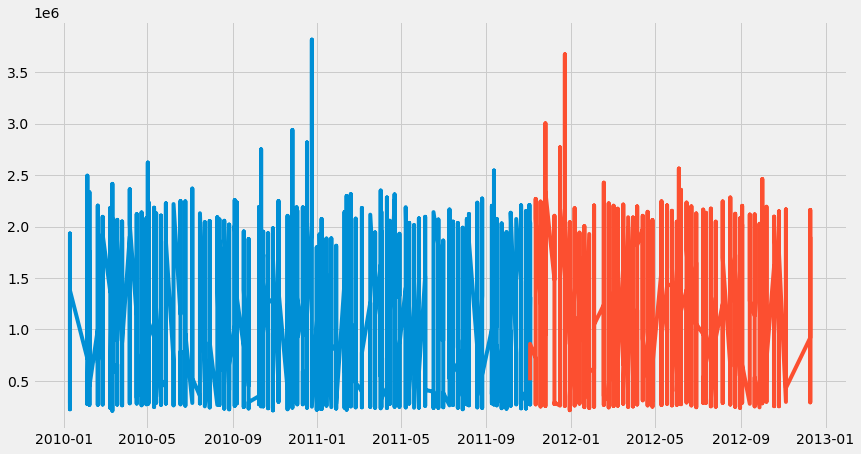

In [24]:

train_size = .65
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.weekly_sales)
plt.plot(test.index, test.weekly_sales)

<AxesSubplot:xlabel='date'>

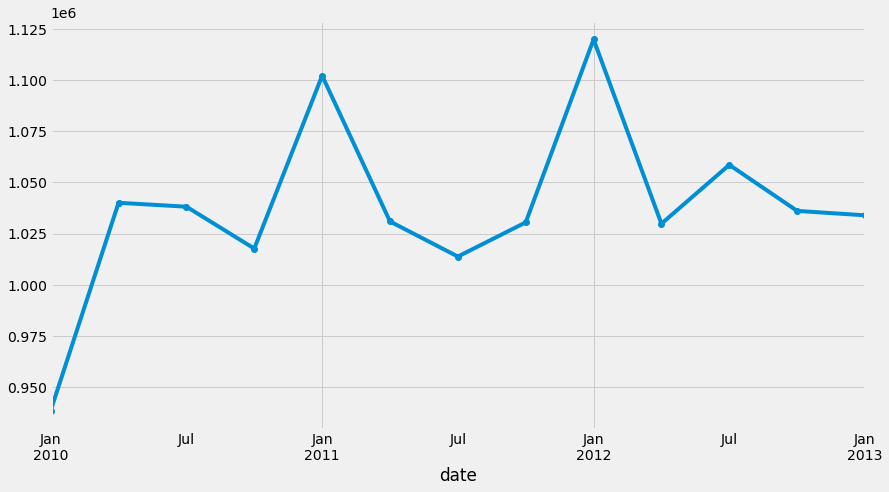

In [17]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('3M').mean().plot(marker='o')

KeyError: '2010-01-10'

In [ ]:
# Establish taget 
y = 'weekly_sales'

#features to predict y
features = [i for i in df.columns if i not in [y]]
original_df = df.copy(deep=True)

In [ ]:
df.head()